# Solves the two-species two-dimensional adhesion equation on a rectangualr lattice and computes the psuedo-1D average of the 2D solution.
### Solving the two-species differential adhesion equation in 2d using py-pde package. Refer to the documentation at: https://py-pde.readthedocs.io/en/latest/index.html


In [94]:
#import modules
import numpy as np
from numpy import log
#imprort modules from the py-pde package
from pde import PDE, CartesianGrid, ScalarField, DiffusionPDE, FieldCollection, PDEBase, UnitGrid
import pde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import io
from scipy import integrate

### Initialise the domain, discretisation, initial and boundary conditions

In [95]:
L_x=200
L_y=20
dx=0.5
dy=0.5
T_final=1000

n_pde_pts_x=np.int64(L_x/dx) #cols
n_pde_pts_y=np.int64(L_y/dy) #rows



grid = CartesianGrid([[0, L_y], [0, L_x]], [n_pde_pts_y,n_pde_pts_x])

bc_x = {"derivative": 0}
bc_y = {"derivative": 0}


A=ScalarField(grid,label="A")
B=ScalarField(grid,label="B")
A.data[:,int(np.floor(0.40*n_pde_pts_x)):int(np.ceil(0.60*n_pde_pts_x))]=1
B.data[:,0:int(np.floor(0.40*n_pde_pts_x))]=0.5
B.data[:,int(np.ceil(0.60*n_pde_pts_x)):n_pde_pts_x]=0.5

state = FieldCollection([A, B])

### Define the PDE

In [96]:
#adhesion and movement parameters
p=0 #A to A
q=0 #B to B
r=0 #A to B (or B to A)
rho=1 #swapping prob 
D_a=0.25 #diff coeff A
D_b=0.25 #diff coeff B

#Define PDE
eq=PDE(
    {
        "A": f"divergence({D_a}*((1-{p})**(4*A)*(1-{r})**(4*B)*(4*log(1-{r})*(1-A-B)+1)*A*gradient(B)+(1-{p})**(4*A)*(1-{r})**(4*B)*(4*log(1-{p})*A*(1-A-B)+1-B)*gradient(A))+({D_a}+{D_b})*{rho}*(1-{p})**(4*A)*(1-{q})**(4*B)*(1-{r})**(4*A+4*B)*(B*(1-4*log(1-{r})*A+4*log(1-{p})*A)*gradient(A)-A*(1-4*log(1-{q})*B+4*log(1-{r})*B)*gradient(B)))",
        "B": f"divergence({D_b}*((1-{q})**(4*B)*(1-{r})**(4*A)*(4*log(1-{r})*(1-B-A)+1)*B*gradient(A)+(1-{q})**(4*B)*(1-{r})**(4*A)*(4*log(1-{q})*B*(1-B-A)+1-A)*gradient(B))+({D_b}+{D_a})*{rho}*(1-{q})**(4*B)*(1-{p})**(4*A)*(1-{r})**(4*B+4*A)*(A*(1-4*log(1-{r})*B+4*log(1-{q})*B)*gradient(B)-B*(1-4*log(1-{p})*A+4*log(1-{r})*A)*gradient(A)))"
    }, bc=[bc_x,bc_y]
)

#this line ensure all your solutions (in time) are stored and not just the one at the last time point
storage = pde.MemoryStorage()

### Solve the PDE

In [97]:
result = eq.solve(state, t_range=T_final, dt=1e-2, adaptive=True, tracker=["progress", storage.tracker(100)])

  0%|          | 0/1000.0 [00:00<?, ?it/s]

In [98]:
x = np.linspace(0, L_x, n_pde_pts_x)
y = np.linspace(0, L_y,n_pde_pts_y)
X, Y = np.meshgrid(x, y)

In [99]:
#extract pde solution at t=0,100 and 1000
sol_t0=list(storage.items())[0][1].data
sol_t100=list(storage.items())[1][1].data
sol_t1000=list(storage.items())[10][1].data

sol_A_t0=sol_t0[0,:,:]
sol_B_t0=sol_t0[1,:,:]

sol_A_t100=sol_t100[0,:,:]
sol_B_t100=sol_t100[1,:,:]

sol_A_t1000=sol_t1000[0,:,:]
sol_B_t1000=sol_t1000[1,:,:]

In [100]:
len(list(storage.items())[:])

11

In [101]:
#pseudo 1D solution: average over the vertical extent of the domain 
sol_A_t0_1D=integrate.trapezoid(sol_A_t0,y,axis=0)/L_y
sol_B_t0_1D=integrate.trapezoid(sol_B_t0,y,axis=0)/L_y

sol_A_t100_1D=integrate.trapezoid(sol_A_t100,y,axis=0)/L_y
sol_B_t100_1D=integrate.trapezoid(sol_B_t100,y,axis=0)/L_y

sol_A_t1000_1D=integrate.trapezoid(sol_A_t1000,y,axis=0)/L_y
sol_B_t1000_1D=integrate.trapezoid(sol_B_t1000,y,axis=0)/L_y

### Plot psuedo-1D solution

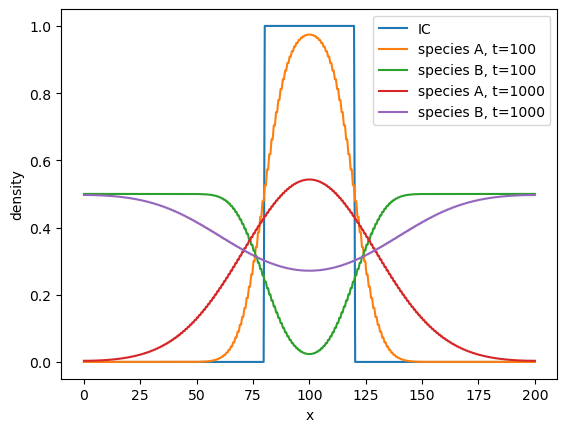

In [102]:
plt.plot(x,sol_A_t0_1D,label='IC')
plt.plot(x,sol_A_t100_1D,label="species A, t=100")
plt.plot(x,sol_B_t100_1D,label="species B, t=100")
plt.plot(x,sol_A_t1000_1D,label="species A, t=1000")
plt.plot(x,sol_B_t1000_1D,label="species B, t=1000")

plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.show()

### Plot 2D solution

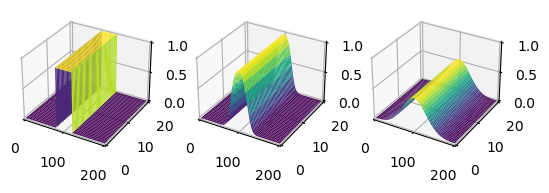

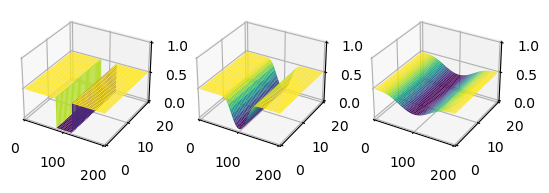

In [103]:
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, Y, sol_A_t0, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, Y, sol_A_t100, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, Y, sol_A_t1000, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

plt.show()

#species B
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, Y, sol_B_t0, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, Y, sol_B_t100, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, Y, sol_B_t1000, cmap='viridis')
ax.set_xlim([0,L_x])
ax.set_ylim([0,L_y])
ax.set_zlim([0,1])

plt.show()

plt.show()

In [104]:
#save 1D data to save in .mat format
sol_1D=np.empty((3,n_pde_pts_x,2))

sol_1D[0,:,0]=sol_A_t0_1D
sol_1D[1,:,0]=sol_A_t100_1D
sol_1D[2,:,0]=sol_A_t1000_1D


sol_1D[0,:,1]=sol_B_t0_1D
sol_1D[1,:,1]=sol_B_t100_1D
sol_1D[2,:,1]=sol_B_t1000_1D


data_dict={"sol_1D": sol_1D, "x": x, "y": y, "dx": dx, "dy": dy, "p":p, "q" : q, "r":r, "L_x":L_x, "L_y":L_y, "n_pde_pts_x":n_pde_pts_x, "n_pde_pts_y":n_pde_pts_y, "T_final":T_final, "D_a":D_a, "D_b":D_b, "rho":rho}
io.savemat('ts_2d_pde_data_p_'+str(p)+'_q_'+str(q)+'_r_'+str(r)+'_rho_'+str(rho)+'_T_'+str(T_final)+'.mat',data_dict)
